### Learning reaction types using different bit sizes of the transformation fingerprints (AP3) and different agent fingerprints

Goal: further reduce the size/complexity of the FP/model

In [1]:
import _pickle as cPickle
import gzip
from collections import defaultdict
import random
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import utilsFunctions
from pylab import rcParams

Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

In [3]:
dataDir = "../data/"


with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)
# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the AP3 fingerprint, agent feature and MG2 fingerprints

In [4]:
infile = gzip.open(dataDir+"transformationFPs_MG2_agentFPs_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_agentFeature,fp_agentMG2 = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3,fp_agentFeature,fp_agentMG2])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


Combine the transformation FP with agent feature as well as Morgan2 FP. Try different bit sizes. Split the FPs in training (20 %) and test data (80 %) per recation type (200, 800)

In [6]:
import numpy as np

random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
#fpsz=4096
#fpsz=2048
#fpsz=1024
#fpsz=512
fpsz=256
#fpsz=128
trainFps_AP3=[]
trainFps_AP3_agentFeature=[]
trainFps_AP3_agentMG2=[]
trainActs=[]
testFps_AP3=[]
testFps_AP3_agentFeature=[]
testFps_AP3_agentMG2=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        np1_feature = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2_feature = np.asarray(fps[x][4], dtype=float)
        trainFps_AP3_agentFeature += [np.concatenate([np1_feature, np2_feature])]
        np1_morgan = utilsFunctions.fpToNP(fps[x][3],fpsz)
        trainFps_AP3 += [np1_morgan]
        np2_morgan = utilsFunctions.fpToNP(fps[x][5],fpsz)
        trainFps_AP3_agentMG2 += [np.concatenate([np1_morgan, np2_morgan])]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        np1_feature = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2_feature = np.asarray(fps[x][4], dtype=float)
        testFps_AP3_agentFeature += [np.concatenate([np1_feature, np2_feature])]
        np1_morgan = utilsFunctions.fpToNP(fps[x][3],fpsz)
        testFps_AP3 += [np1_morgan]
        np2_morgan = utilsFunctions.fpToNP(fps[x][5],fpsz)
        testFps_AP3_agentMG2 += [np.concatenate([np1_morgan, np2_morgan])]
    testActs += [i]*nTest

building fp collection


Build the LR classifiers

In [9]:
print('training models')
lr_cls_AP3 = LogisticRegression(solver='liblinear')
result_lr_fp_AP3 = lr_cls_AP3.fit(trainFps_AP3,trainActs)
lr_cls_AP3_feature = LogisticRegression(solver='liblinear')
result_lr_fp_AP3_feature = lr_cls_AP3_feature.fit(trainFps_AP3_agentFeature,trainActs)
lr_cls_AP3_MG2 = LogisticRegression(solver='liblinear')
result_lr_fp_AP3_MG2 = lr_cls_AP3_MG2.fit(trainFps_AP3_agentMG2,trainActs)

training models


Evalutate the LR classifier using our test data

In [10]:
cmat_fp_AP3 = utilsFunctions.evaluateModel(result_lr_fp_AP3, testFps_AP3, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9825  0.9680  0.9752     1.2.1 Aldehyde reductive amination
 1  0.9862  0.9517  0.9687     1.2.4 Eschweiler-Clarke methylation
 2  0.9762  0.9911  0.9836     1.2.5 Ketone reductive amination
 3  0.9700  0.9700  0.9700     1.3.6 Bromo N-arylation
 4  0.9738  0.9500  0.9617     1.3.7 Chloro N-arylation
 5  0.9750  0.9714  0.9732     1.3.8 Fluoro N-arylation
 6  0.9437  0.9729  0.9581     1.6.2 Bromo N-alkylation
 7  0.9337  0.9396  0.9367     1.6.4 Chloro N-alkylation
 8  0.8738  0.8118  0.8417     1.6.8 Iodo N-alkylation
 9  0.9738  0.8792  0.9241     1.7.4 Hydroxy to methoxy
10  0.7100  0.8490  0.7733     1.7.6 Methyl esterification
11  0.9237  0.9660  0.9444     1.7.7 Mitsunobu aryl ether synthesis
12  0.9313  0.9454  0.9383     1.7.9 Williamson ether synthesis
13  0.9825  0.9692  0.9758     1.8.5 Thioether synthesis
14  0.9213  0.9534  0.9371    10.1.1 Bromination
15  0.9375  0.9422  0.9398    10.1.2 Chlorination
16  0.9738  0.9454

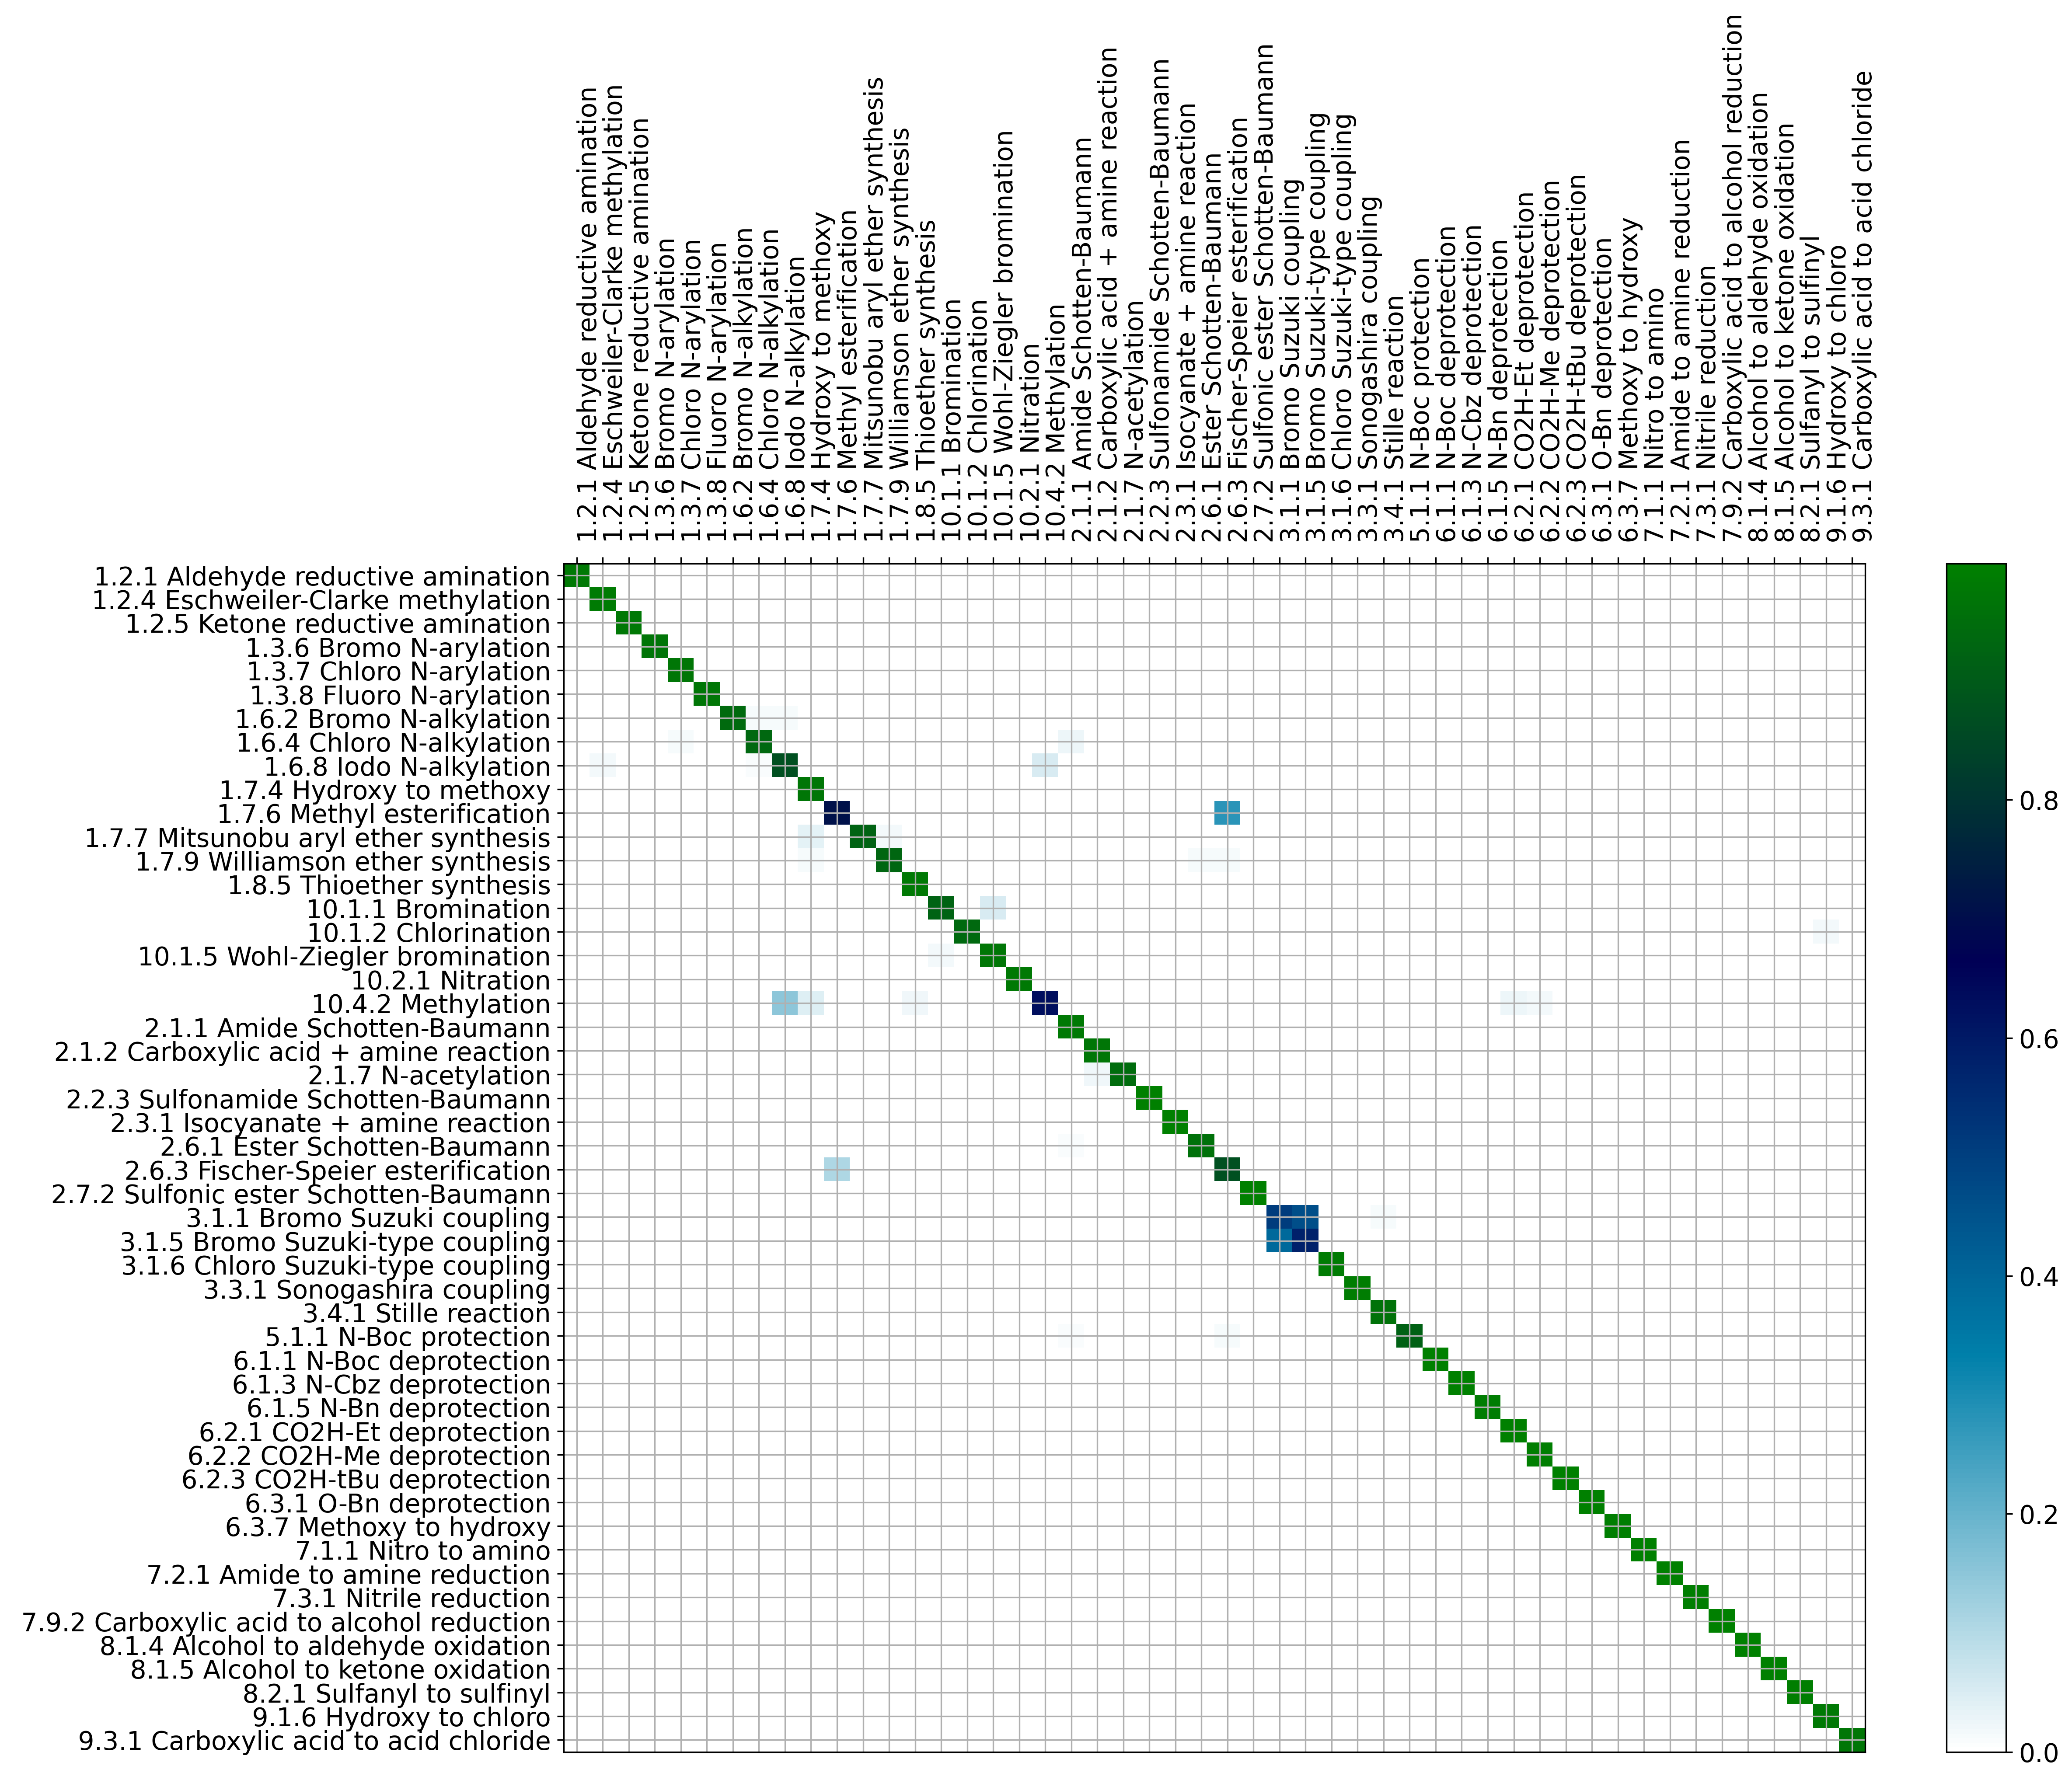

In [11]:
utilsFunctions.labelled_cmat(cmat_fp_AP3,rtypes,figsize=(16,12), labelExtras=names_rTypes)

In [12]:
cmat_fp_AP3_feature = utilsFunctions.evaluateModel(result_lr_fp_AP3_feature, testFps_AP3_agentFeature, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9838  0.9505  0.9668     1.2.1 Aldehyde reductive amination
 1  0.9875  0.9599  0.9735     1.2.4 Eschweiler-Clarke methylation
 2  0.9738  0.9836  0.9786     1.2.5 Ketone reductive amination
 3  0.9750  0.9677  0.9714     1.3.6 Bromo N-arylation
 4  0.9738  0.9558  0.9647     1.3.7 Chloro N-arylation
 5  0.9788  0.9775  0.9781     1.3.8 Fluoro N-arylation
 6  0.9363  0.9715  0.9535     1.6.2 Bromo N-alkylation
 7  0.9200  0.9352  0.9275     1.6.4 Chloro N-alkylation
 8  0.8738  0.8312  0.8519     1.6.8 Iodo N-alkylation
 9  0.9688  0.9012  0.9337     1.7.4 Hydroxy to methoxy
10  0.9600  0.9759  0.9679     1.7.6 Methyl esterification
11  0.9275  0.9574  0.9422     1.7.7 Mitsunobu aryl ether synthesis
12  0.9387  0.9616  0.9500     1.7.9 Williamson ether synthesis
13  0.9788  0.9691  0.9739     1.8.5 Thioether synthesis
14  0.9300  0.9575  0.9436    10.1.1 Bromination
15  0.9413  0.9436  0.9424    10.1.2 Chlorination
16  0.9788  0.9491

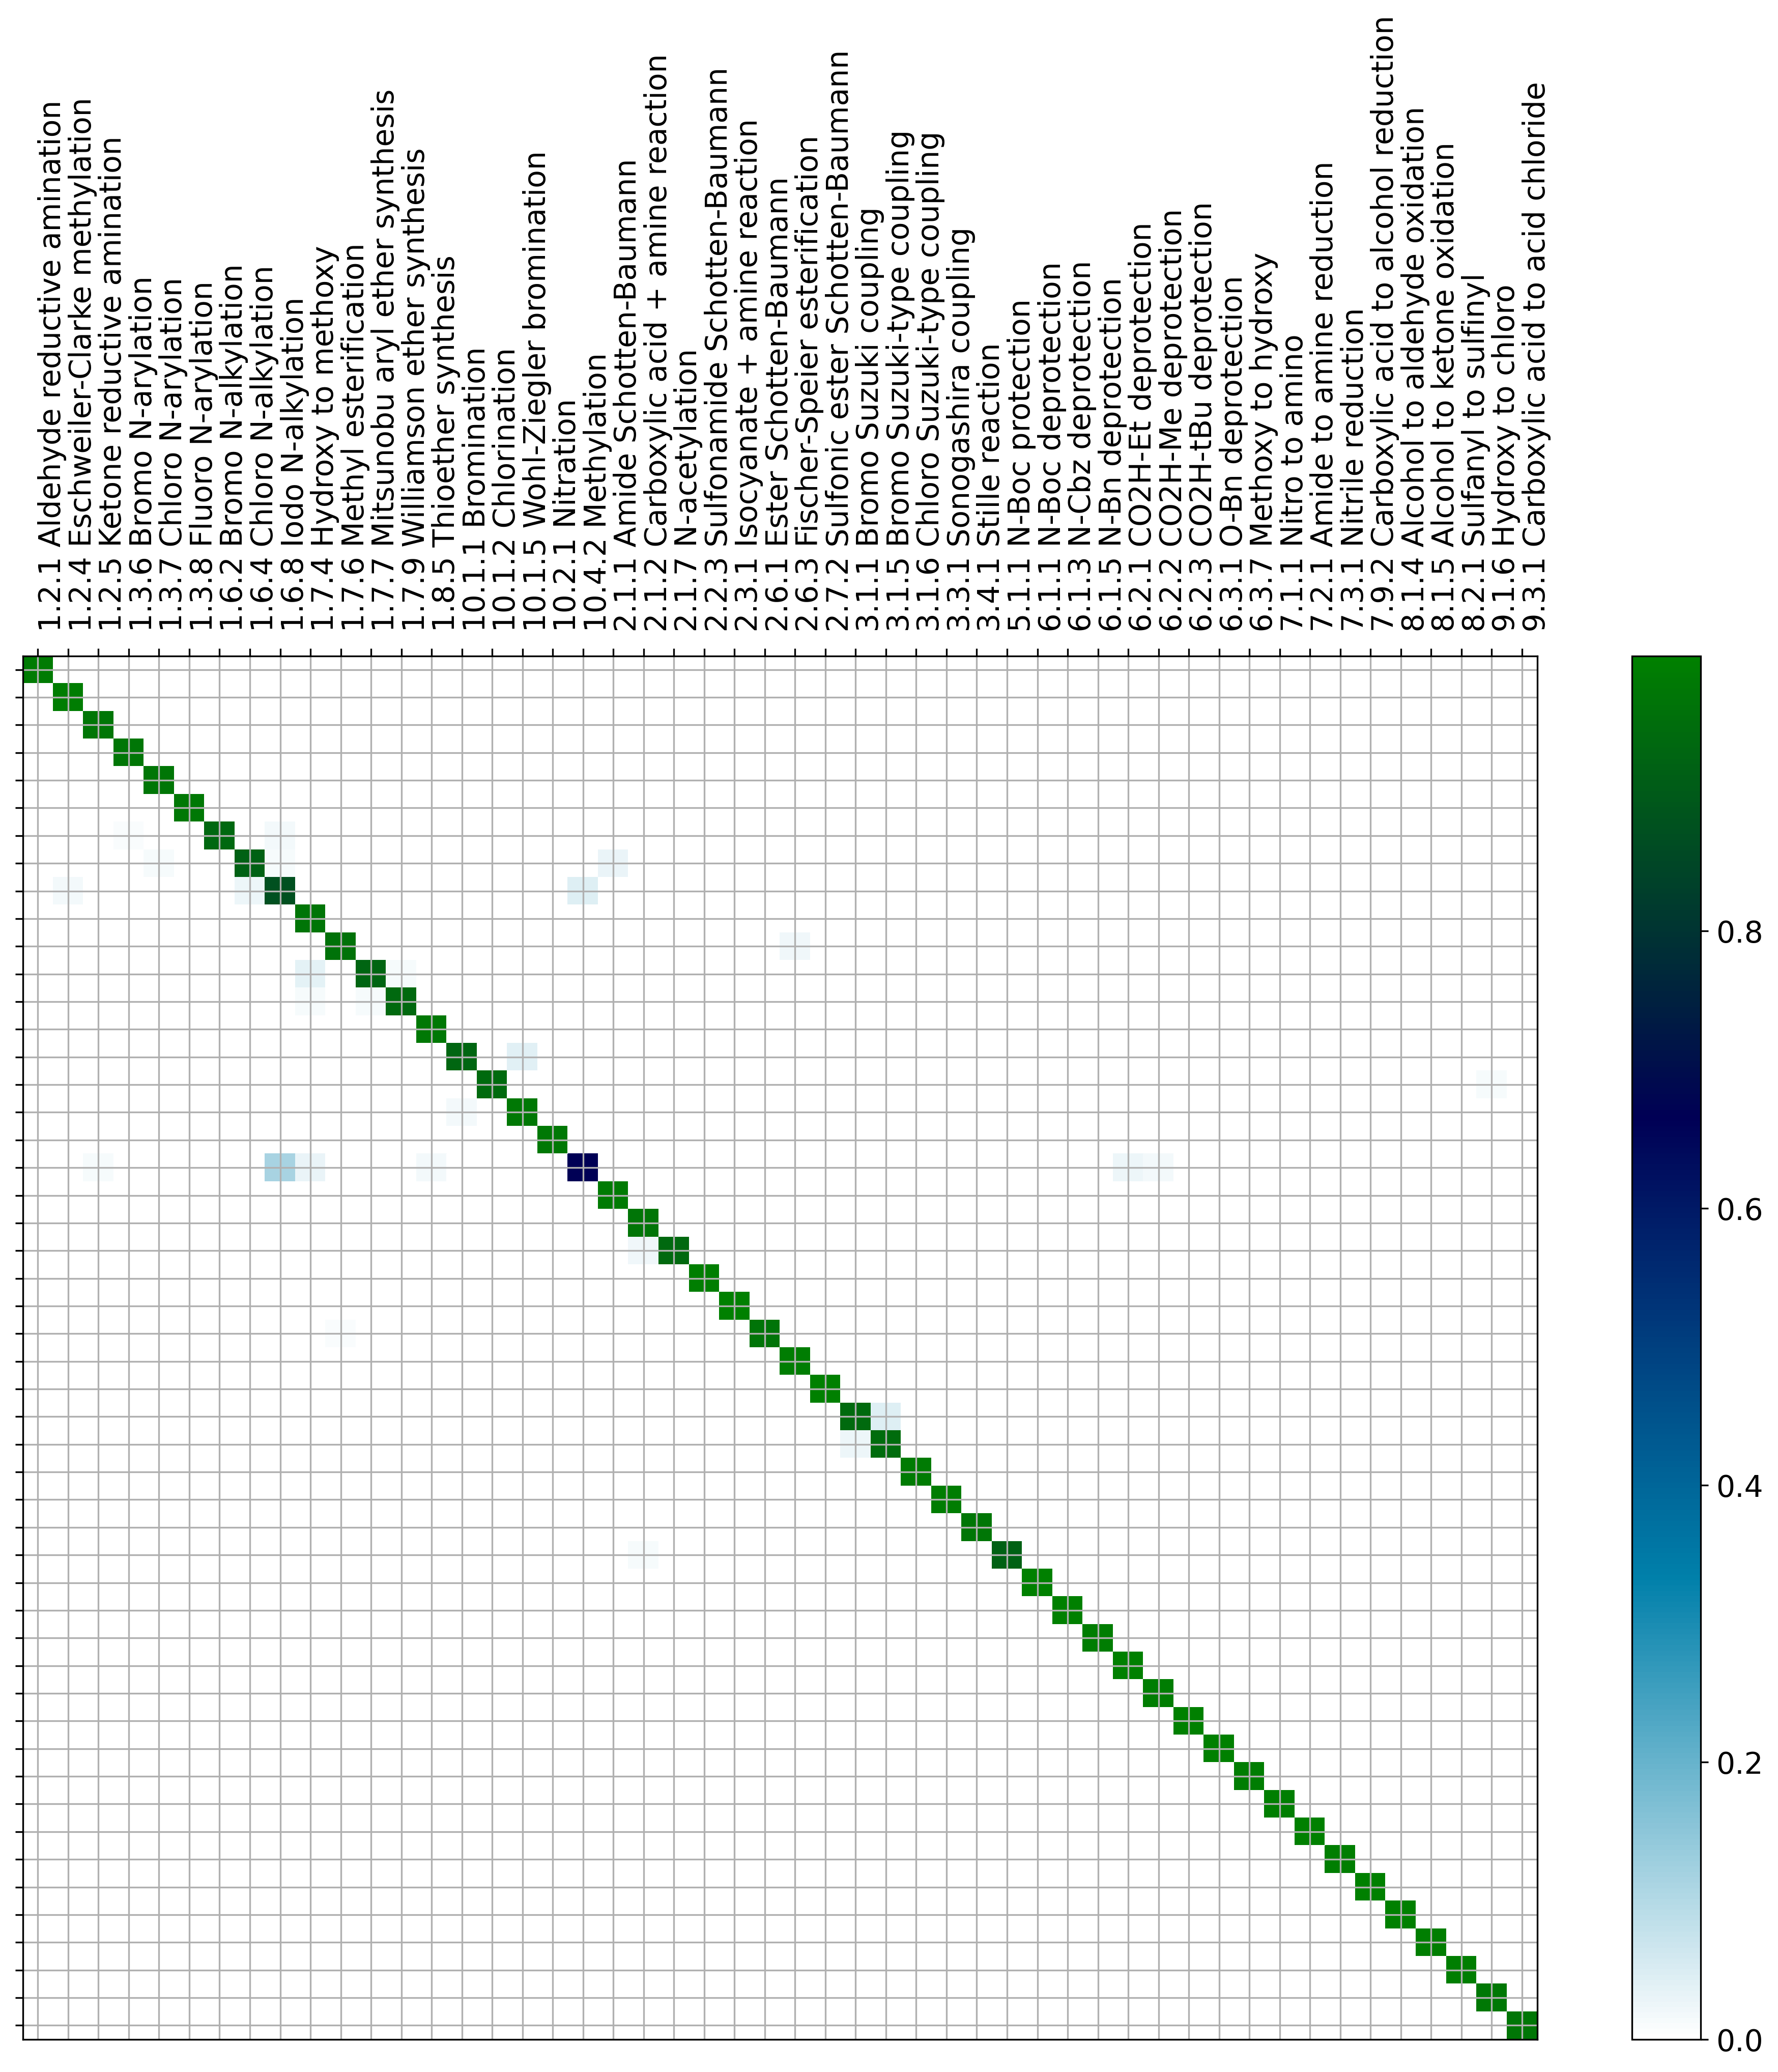

In [13]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_feature,rtypes,figsize=(16,12), labelExtras=names_rTypes, ylabel=False)

In [14]:
cmat_fp_AP3_MG2 = utilsFunctions.evaluateModel(result_lr_fp_AP3_MG2, testFps_AP3_agentMG2, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9838  0.9528  0.9680     1.2.1 Aldehyde reductive amination
 1  0.9775  0.9513  0.9642     1.2.4 Eschweiler-Clarke methylation
 2  0.9800  0.9788  0.9794     1.2.5 Ketone reductive amination
 3  0.9738  0.9582  0.9659     1.3.6 Bromo N-arylation
 4  0.9700  0.9510  0.9604     1.3.7 Chloro N-arylation
 5  0.9750  0.9824  0.9787     1.3.8 Fluoro N-arylation
 6  0.9337  0.9639  0.9486     1.6.2 Bromo N-alkylation
 7  0.9150  0.9337  0.9242     1.6.4 Chloro N-alkylation
 8  0.8962  0.8841  0.8901     1.6.8 Iodo N-alkylation
 9  0.9475  0.8970  0.9216     1.7.4 Hydroxy to methoxy
10  0.9838  0.9716  0.9776     1.7.6 Methyl esterification
11  0.9237  0.9499  0.9366     1.7.7 Mitsunobu aryl ether synthesis
12  0.9400  0.9629  0.9513     1.7.9 Williamson ether synthesis
13  0.9762  0.9775  0.9769     1.8.5 Thioether synthesis
14  0.9337  0.9589  0.9462    10.1.1 Bromination
15  0.9375  0.9305  0.9340    10.1.2 Chlorination
16  0.9912  0.9730

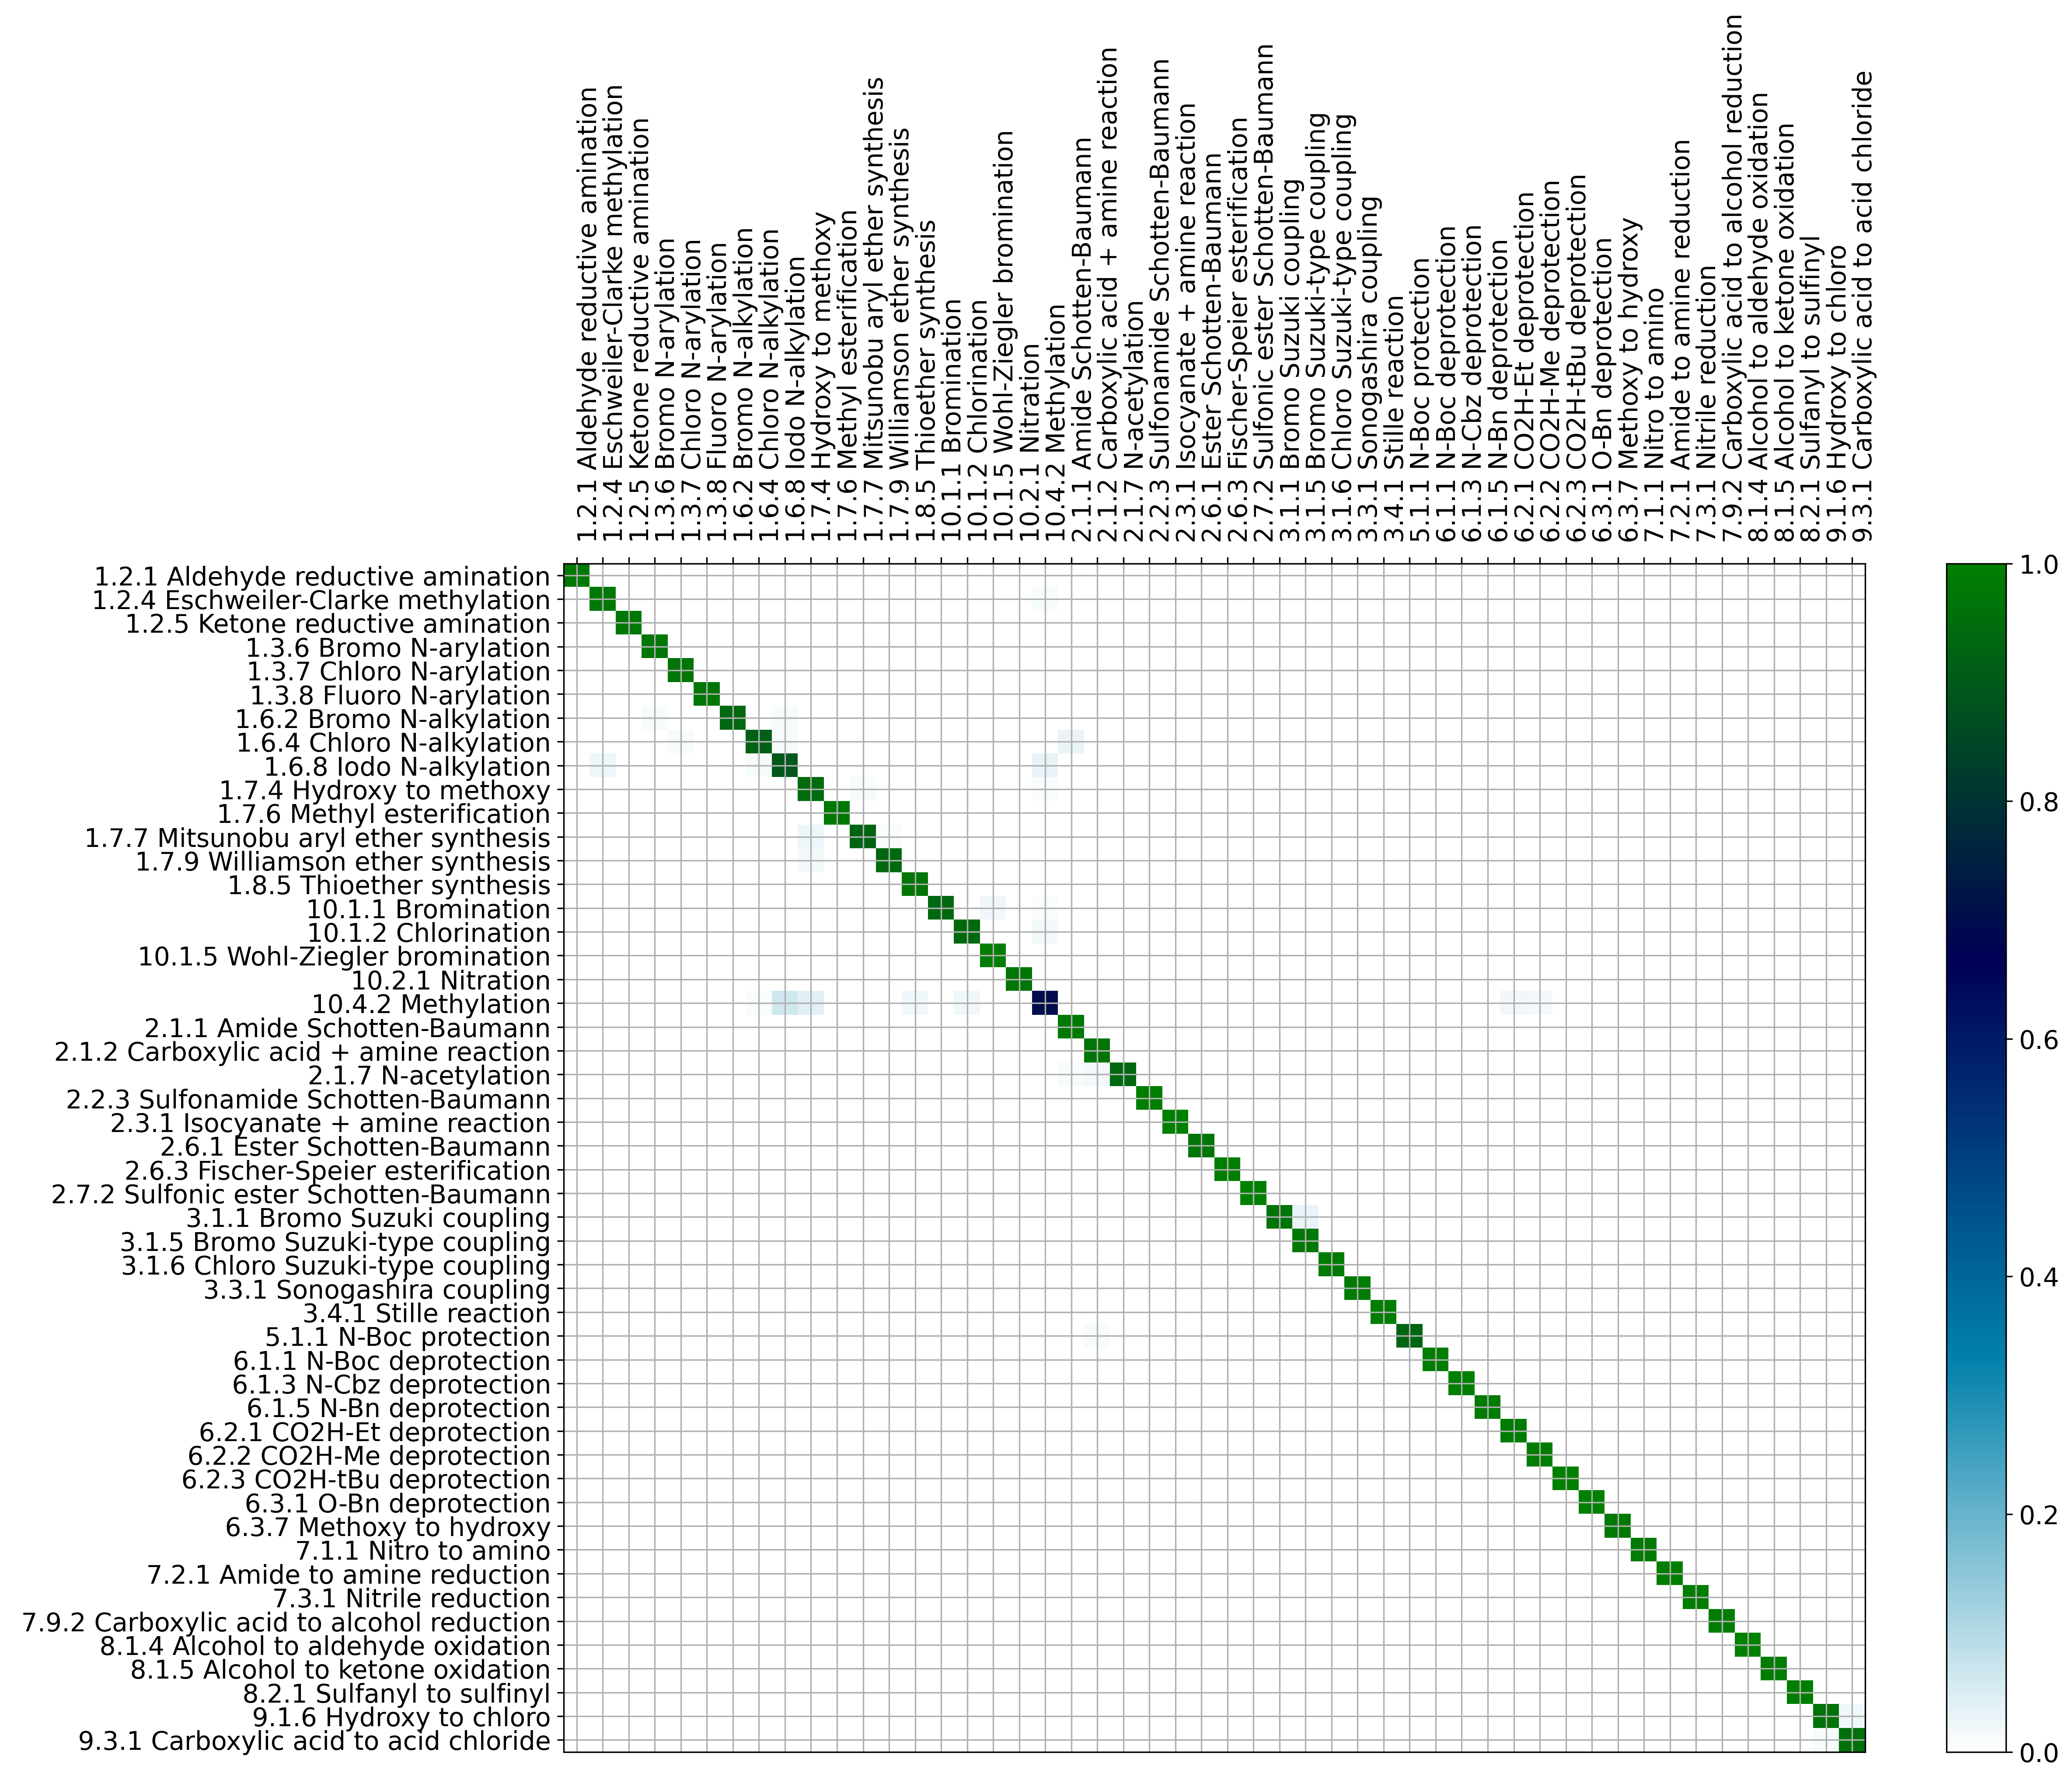

In [15]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_MG2,rtypes,figsize=(16,12),labelExtras=names_rTypes)

#### Using DictVectorizer functionality to check the performance of the unfolded version of the fingerprint

In [16]:
from sklearn.feature_extraction import DictVectorizer

Build the unfolded FP using the DictVectorizer functionality. In this experiment ignore the agents.

In [19]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200

trainFps_AP3_unfolded=[]
trainActs=[]
testFps_AP3_unfolded=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        trainFps_AP3_unfolded.append(fps[x][3])
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        testFps_AP3_unfolded.append(fps[x][3])
    testActs += [i]*nTest
dictVectmodel = utilsFunctions.prepareUnfoldedData(trainFps_AP3_unfolded+testFps_AP3_unfolded)
trainFps_new = [x.GetNonzeroElements() for x in trainFps_AP3_unfolded]
testFps_new = [x.GetNonzeroElements() for x in testFps_AP3_unfolded]
trainFps_new = dictVectmodel.transform(trainFps_new)
testFps_new = dictVectmodel.transform(testFps_new)

building fp collection


Look at the number of unique bits

In [20]:
len(dictVectmodel.feature_names_)

1232

Train the LR classifier with the unfolded version of the FP

In [22]:
print('training model')
lr_cls_AP3_unfolded =  LogisticRegression(solver='liblinear')
result_lr_fp_AP3_unfolded = lr_cls_AP3_unfolded.fit(trainFps_new,trainActs)

training model


In [23]:
cmat_fp_AP3_unfolded = utilsFunctions.evaluateModel(result_lr_fp_AP3_unfolded, testFps_new, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9888  0.9741  0.9814     1.2.1 Aldehyde reductive amination
 1  0.9862  0.9634  0.9747     1.2.4 Eschweiler-Clarke methylation
 2  0.9850  0.9899  0.9875     1.2.5 Ketone reductive amination
 3  0.9775  0.9751  0.9763     1.3.6 Bromo N-arylation
 4  0.9725  0.9558  0.9641     1.3.7 Chloro N-arylation
 5  0.9862  0.9838  0.9850     1.3.8 Fluoro N-arylation
 6  0.9600  0.9871  0.9734     1.6.2 Bromo N-alkylation
 7  0.9487  0.9535  0.9511     1.6.4 Chloro N-alkylation
 8  0.9113  0.8804  0.8956     1.6.8 Iodo N-alkylation
 9  0.9838  0.9436  0.9633     1.7.4 Hydroxy to methoxy
10  0.7063  0.8679  0.7788     1.7.6 Methyl esterification
11  0.9387  0.9715  0.9549     1.7.7 Mitsunobu aryl ether synthesis
12  0.9650  0.9698  0.9674     1.7.9 Williamson ether synthesis
13  0.9888  0.9790  0.9838     1.8.5 Thioether synthesis
14  0.9200  0.9596  0.9394    10.1.1 Bromination
15  0.9500  0.9694  0.9596    10.1.2 Chlorination
16  0.9750  0.9264

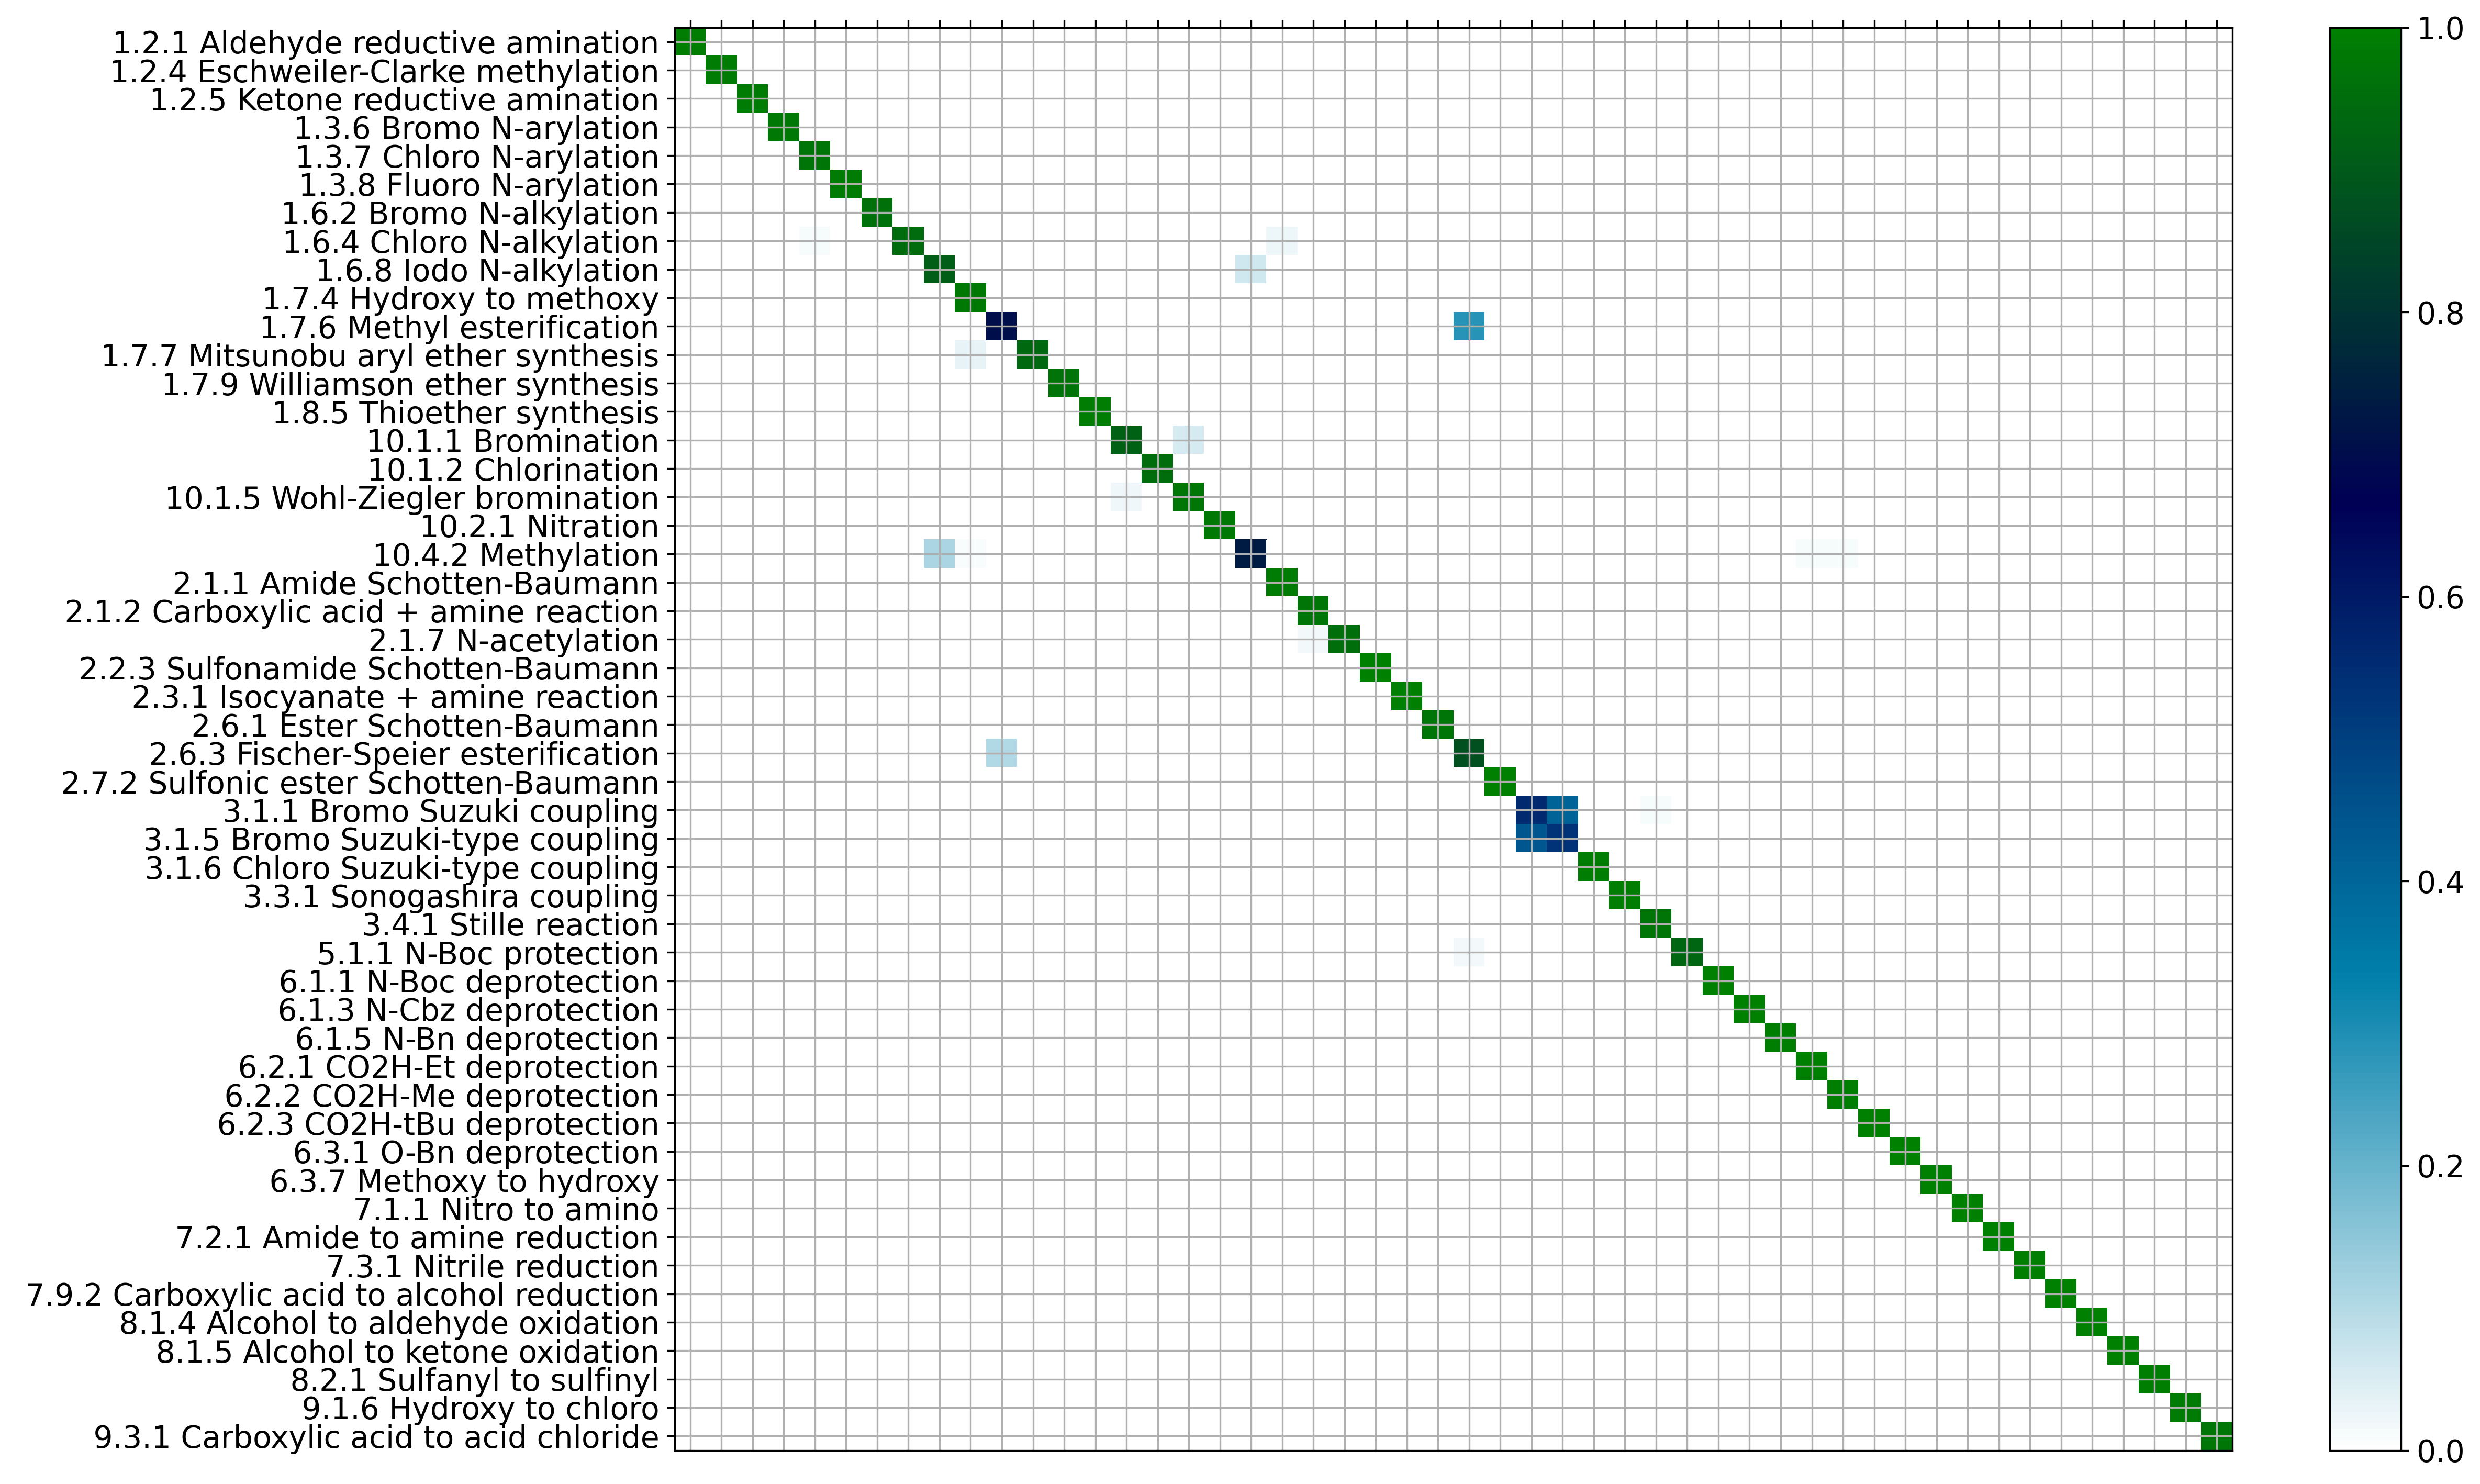

In [24]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_unfolded,rtypes,figsize=(16,12),labelExtras=names_rTypes, xlabel=False)

Build the unfolded FP using the DictVectorizer functionality. Now combine FPs with the agent feature FP.

In [25]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200

trainFps_AP3_feature_unfolded=[]
trainActs=[]
testFps_AP3_feature_unfolded=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        trainFps_AP3_feature_unfolded.append(utilsFunctions.mergeDicts(utilsFunctions.fpToFloatDict(fps[x][3]),utilsFunctions.listToFloatDict(fps[x][4])))
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        testFps_AP3_feature_unfolded.append(utilsFunctions.mergeDicts(utilsFunctions.fpToFloatDict(fps[x][3]),utilsFunctions.listToFloatDict(fps[x][4])))
    testActs += [i]*nTest
    
v = DictVectorizer(sparse=False)
tfp = [x for x in trainFps_AP3_feature_unfolded]
tfp += [x for x in testFps_AP3_feature_unfolded]
dictVectmodel = v.fit(tfp)
trainFps_new = dictVectmodel.transform(trainFps_AP3_feature_unfolded)
testFps_new = dictVectmodel.transform(testFps_AP3_feature_unfolded)

building fp collection


Look at the number of unique bits

In [21]:
len(dictVectmodel.feature_names_)

1241

In [26]:
print('training model')
lr_cls_AP3_feature_unfolded =  LogisticRegression(solver='liblinear')
result_lr_fp_AP3_feature_unfolded = lr_cls_AP3_feature_unfolded.fit(trainFps_new,trainActs)

training model


In [27]:
cmat_fp_AP3_feature_unfolded = utilsFunctions.evaluateModel(result_lr_fp_AP3_feature_unfolded, testFps_new, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9912  0.9671  0.9790     1.2.1 Aldehyde reductive amination
 1  0.9875  0.9693  0.9783     1.2.4 Eschweiler-Clarke methylation
 2  0.9800  0.9937  0.9868     1.2.5 Ketone reductive amination
 3  0.9788  0.9667  0.9727     1.3.6 Bromo N-arylation
 4  0.9738  0.9605  0.9671     1.3.7 Chloro N-arylation
 5  0.9862  0.9862  0.9862     1.3.8 Fluoro N-arylation
 6  0.9563  0.9871  0.9714     1.6.2 Bromo N-alkylation
 7  0.9500  0.9584  0.9542     1.6.4 Chloro N-alkylation
 8  0.9325  0.9165  0.9244     1.6.8 Iodo N-alkylation
 9  0.9788  0.9445  0.9613     1.7.4 Hydroxy to methoxy
10  0.9650  0.9760  0.9705     1.7.6 Methyl esterification
11  0.9425  0.9729  0.9575     1.7.7 Mitsunobu aryl ether synthesis
12  0.9613  0.9859  0.9734     1.7.9 Williamson ether synthesis
13  0.9825  0.9764  0.9794     1.8.5 Thioether synthesis
14  0.9350  0.9677  0.9510    10.1.1 Bromination
15  0.9450  0.9594  0.9521    10.1.2 Chlorination
16  0.9825  0.9402

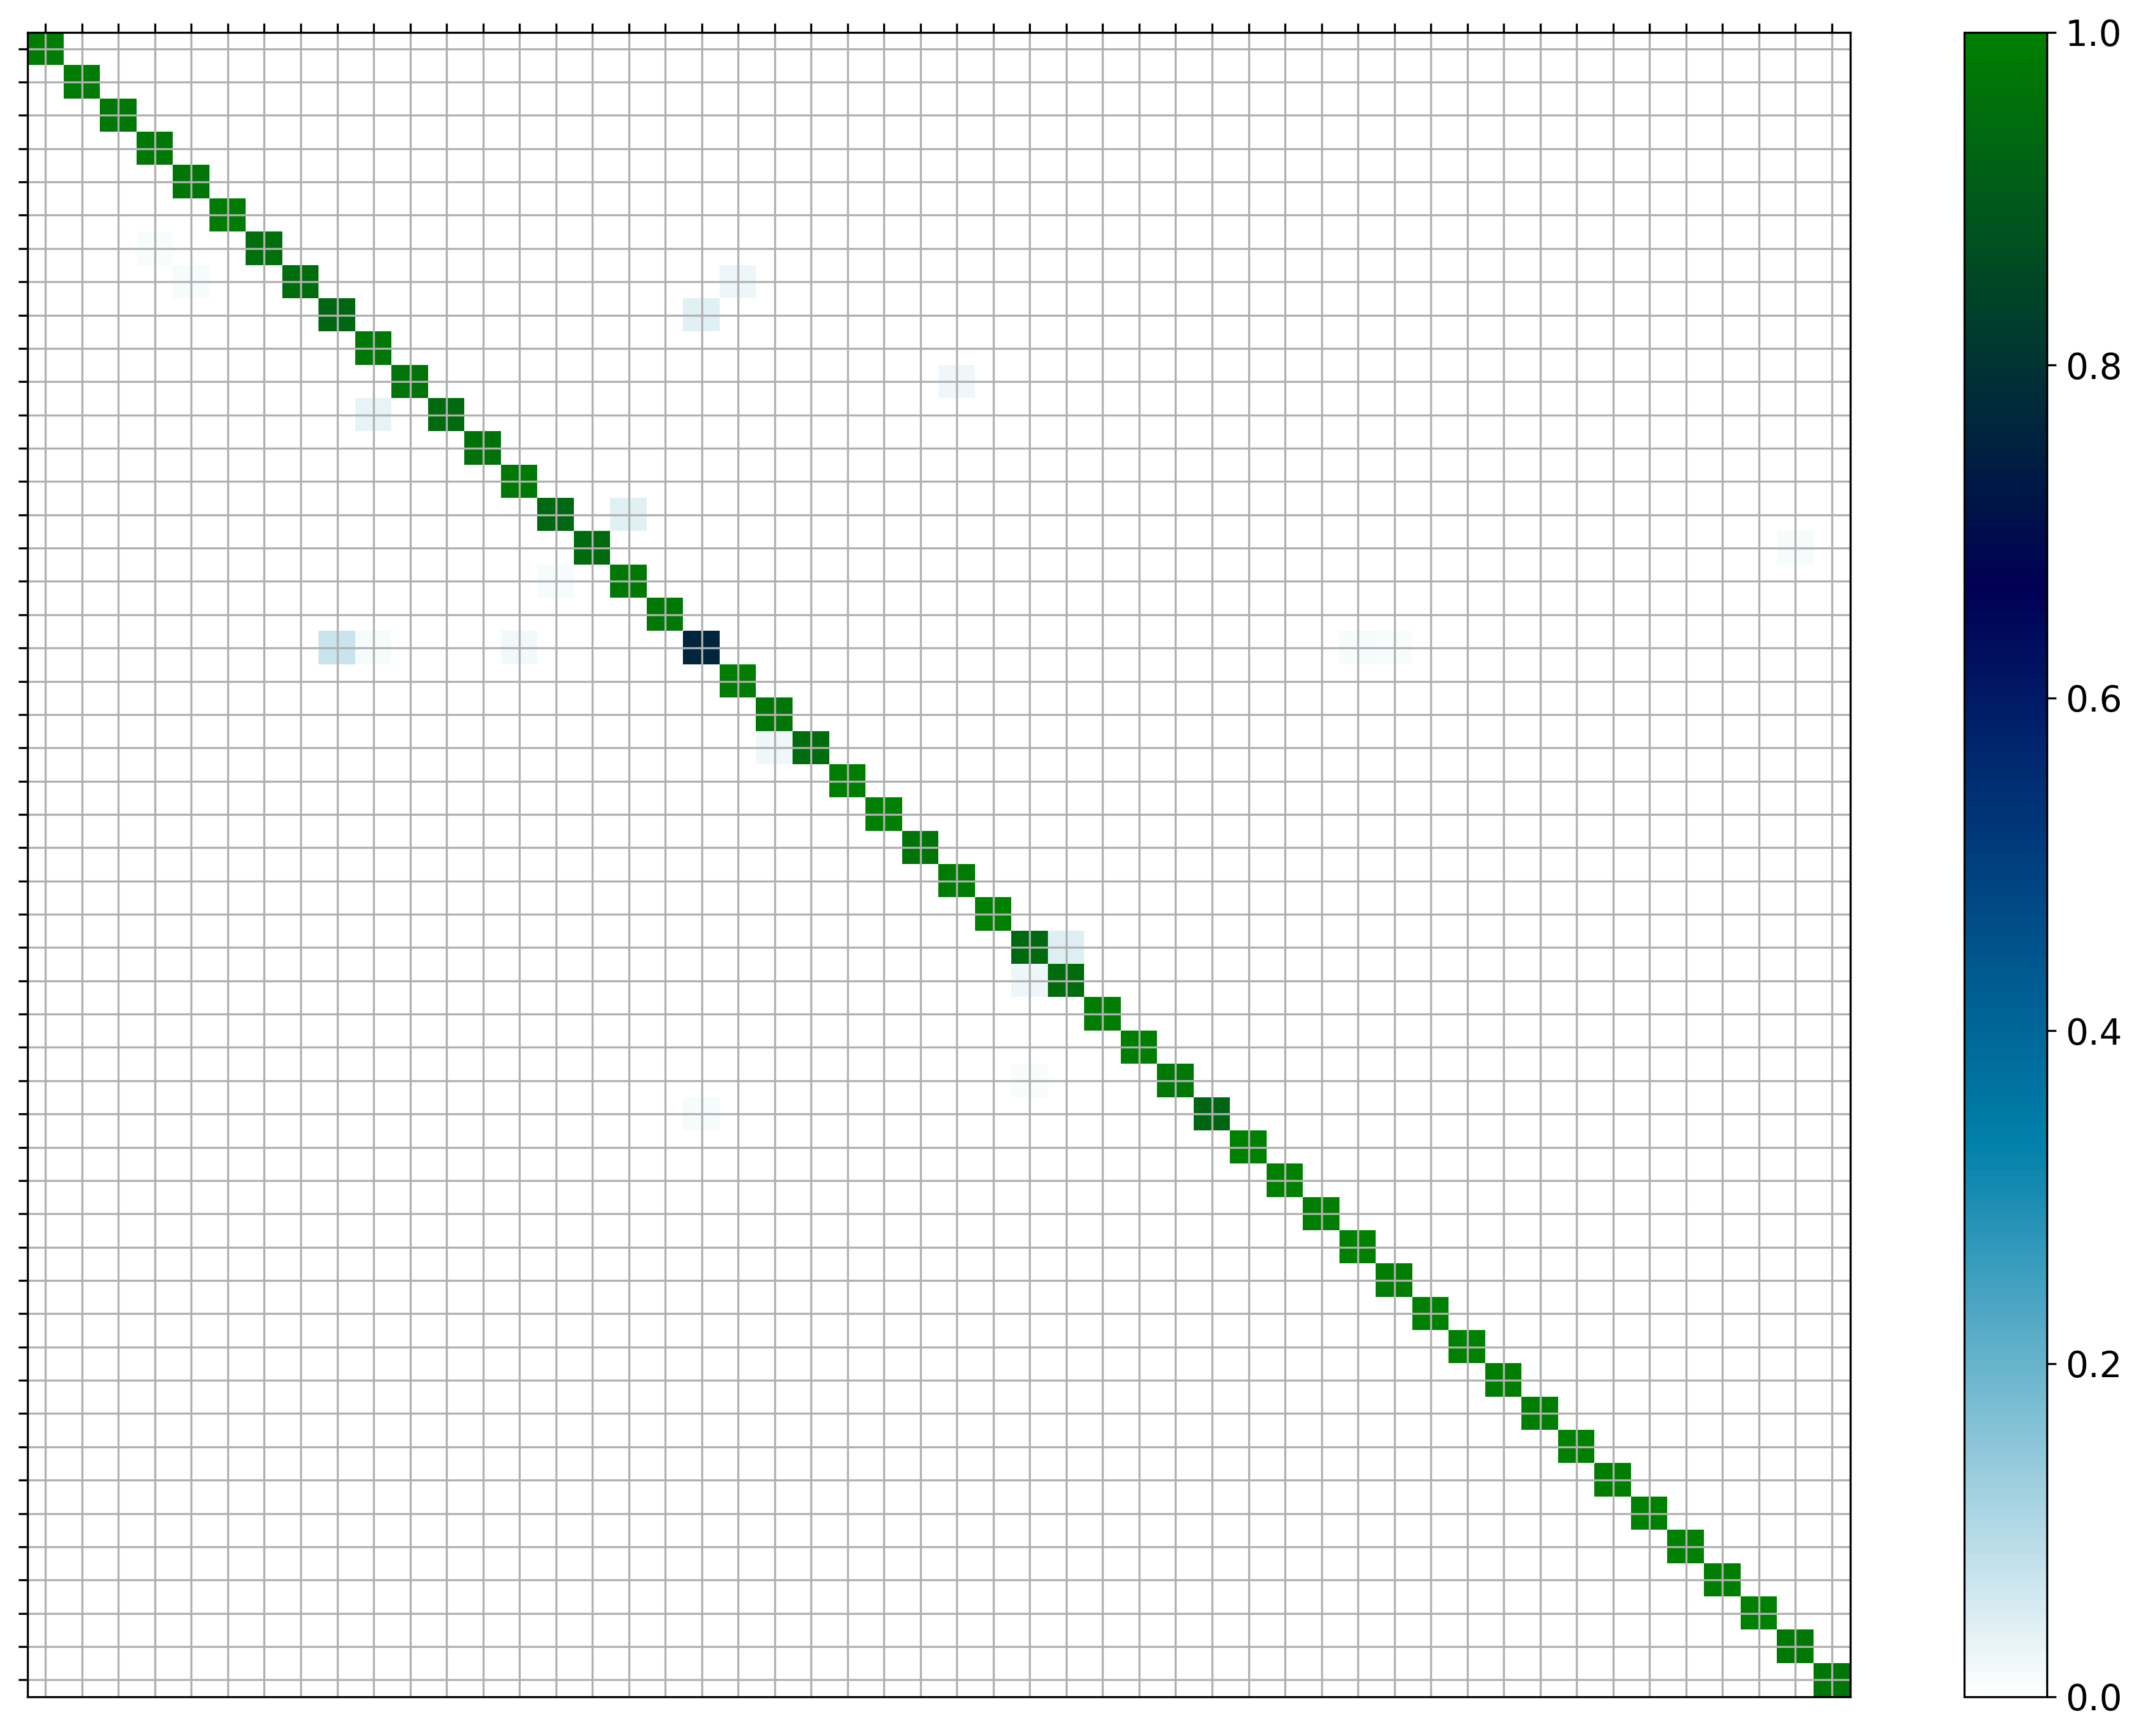

In [28]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_feature_unfolded,rtypes,figsize=(16,12),labelExtras=names_rTypes, xlabel=False, ylabel=False)

Combine the unfolded FPs with the unfolded agent MG2 FP.

In [30]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200

trainFps_AP3_MG2_unfolded=[]
trainActs=[]
testFps_AP3_MG2_unfolded=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        trainFps_AP3_MG2_unfolded.append(utilsFunctions.mergeFps2Dict(fps[x][3],fps[x][5]))
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        testFps_AP3_MG2_unfolded.append(utilsFunctions.mergeFps2Dict(fps[x][3],fps[x][5]))
    testActs += [i]*nTest
    
    
v = DictVectorizer(sparse=False)
tfp = [x for x in trainFps_AP3_MG2_unfolded]
tfp += [x for x in testFps_AP3_MG2_unfolded]
dictVectmodel = v.fit(tfp)
trainFps_new = dictVectmodel.transform(trainFps_AP3_MG2_unfolded)
testFps_new = dictVectmodel.transform(testFps_AP3_MG2_unfolded)

building fp collection


Look at the number of unique bits

In [27]:
len(dictVectmodel.feature_names_)

13828

In [31]:
print('training model')
lr_cls_AP3_MG2_unfolded = LogisticRegression(solver='liblinear')
result_lr_fp_AP3_MG2_unfolded = lr_cls_AP3_MG2_unfolded.fit(trainFps_new,trainActs)

training model


In [32]:
cmat_fp_AP3_MG2_unfolded = utilsFunctions.evaluateModel(result_lr_fp_AP3_MG2_unfolded, testFps_new, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9912  0.9718  0.9814     1.2.1 Aldehyde reductive amination
 1  0.9812  0.9608  0.9709     1.2.4 Eschweiler-Clarke methylation
 2  0.9838  0.9875  0.9856     1.2.5 Ketone reductive amination
 3  0.9800  0.9608  0.9703     1.3.6 Bromo N-arylation
 4  0.9775  0.9607  0.9690     1.3.7 Chloro N-arylation
 5  0.9900  0.9790  0.9845     1.3.8 Fluoro N-arylation
 6  0.9450  0.9793  0.9618     1.6.2 Bromo N-alkylation
 7  0.9387  0.9506  0.9447     1.6.4 Chloro N-alkylation
 8  0.9350  0.9178  0.9263     1.6.8 Iodo N-alkylation
 9  0.9738  0.9397  0.9564     1.7.4 Hydroxy to methoxy
10  0.9862  0.9838  0.9850     1.7.6 Methyl esterification
11  0.9450  0.9643  0.9545     1.7.7 Mitsunobu aryl ether synthesis
12  0.9675  0.9748  0.9711     1.7.9 Williamson ether synthesis
13  0.9788  0.9861  0.9824     1.8.5 Thioether synthesis
14  0.9450  0.9558  0.9503    10.1.1 Bromination
15  0.9600  0.9734  0.9666    10.1.2 Chlorination
16  0.9912  0.9659

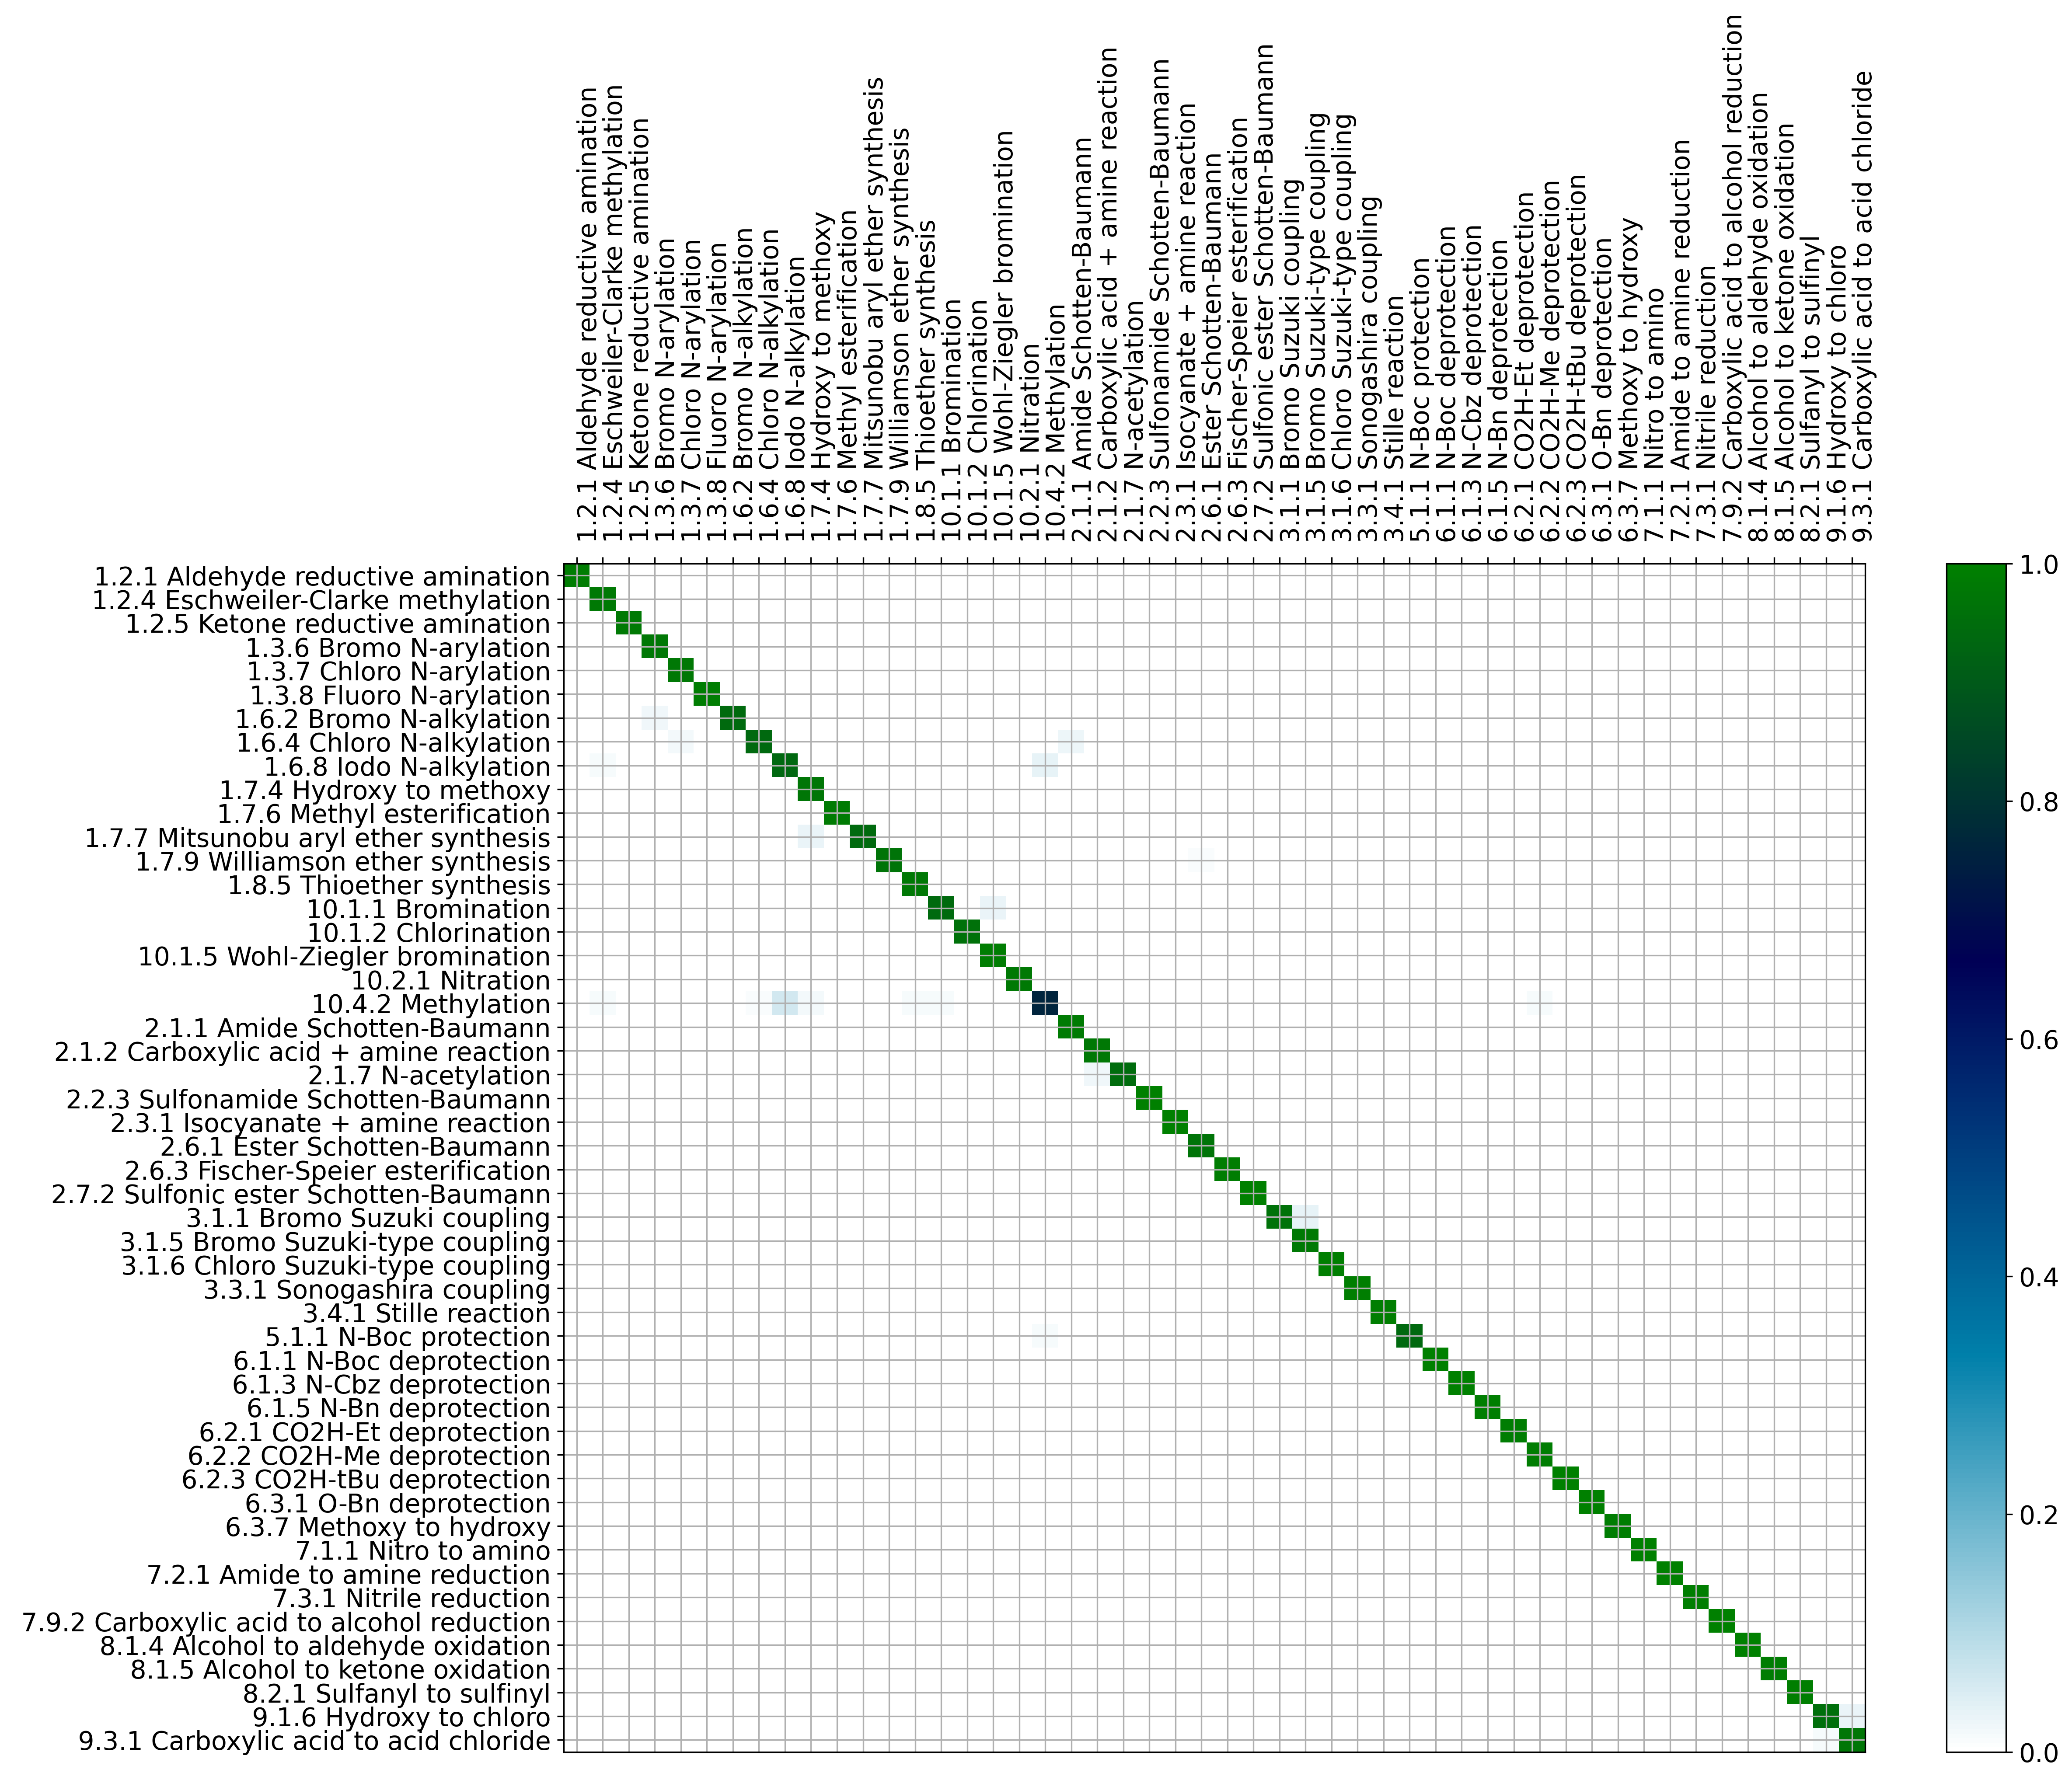

In [33]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_MG2_unfolded,rtypes,figsize=(16,12),labelExtras=names_rTypes)